In [4]:
# Mount Google Drive
from google.colab import drive

drive.mount("/content/drive")
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
REPO_LOC = "/content/drive/MyDrive/Stanford/rhexis-trajectory"

In [6]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(0, f"{REPO_LOC}/Trajectory_Classification")
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Visualization

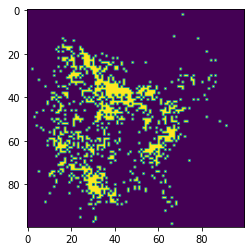

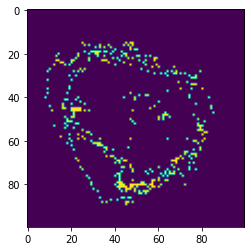

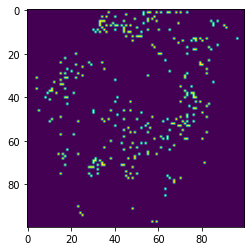

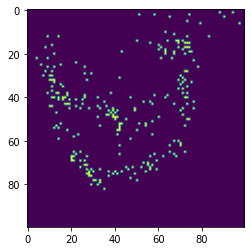

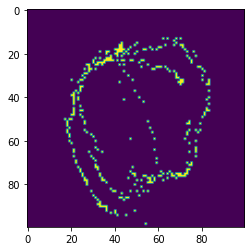

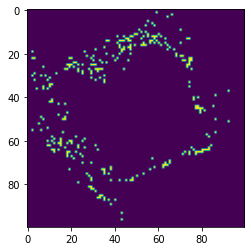

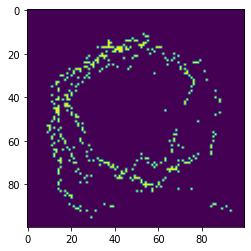

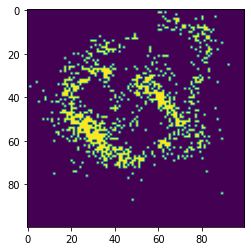

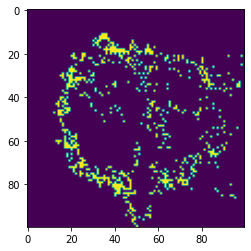

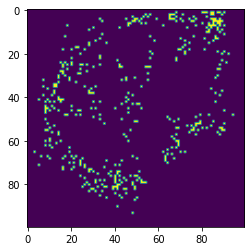

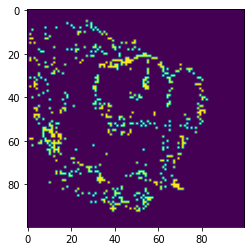

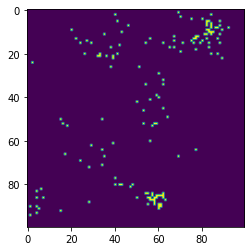

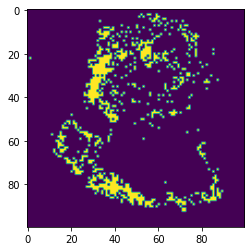

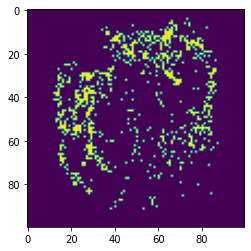

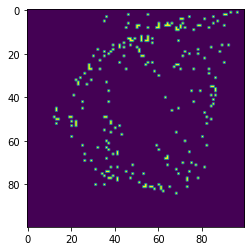

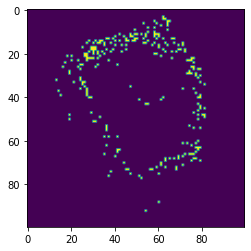

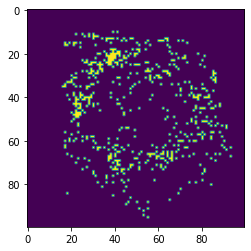

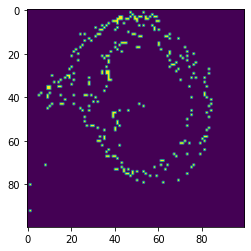

In [7]:
X, y = get_pupil_std_data_traj((100, 100), False)
for i, m in enumerate(X):
    plt.figure()
    plt.imshow(m)
    # plt.show()
    if i == 4:
        plt.savefig("TrajectoryPaths.svg", format="svg", dpi=1200)

# Model Fitting/Prediction

In [9]:
X, y = get_pupil_std_data_traj((100, 100), False)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

# Keep deterministic
np.random.seed(40)
sss = StratifiedShuffleSplit(1, test_size=0.2)
train_ind, test_ind = next(sss.split(X, y))
X_train, X_test = X[train_ind], X[test_ind]
y_train, y_test = y[train_ind], y[test_ind]
# Print to check class balance
y_train, y_test

(array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]), array([1, 1, 0, 0]))

## PCA

In [11]:
def process_for_pca(data):
    """TODO"""
    return np.reshape(data, (-1, 10000))

In [12]:
from sklearn.decomposition import PCA, KernelPCA


def pca(data, n_components):
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(data)
    return pca, pca.components_.reshape((n_components, 100, 100))

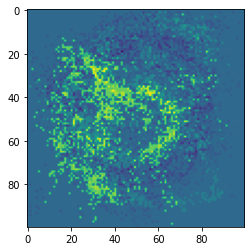

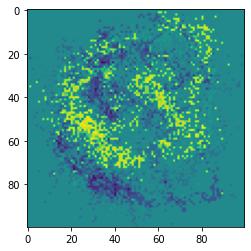

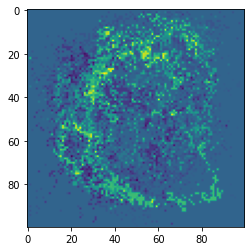

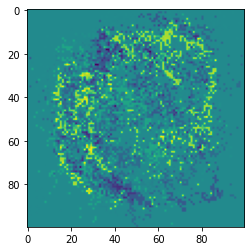

In [13]:
pca_obj, components = pca(process_for_pca(X_train), 4)
# pca_obj.explained_variance_
X_train_pca = pca_obj.transform(process_for_pca(X_train))
for i in components:
    plt.imshow(i)
    plt.show()

In [14]:
# components = pca(process_for_pca(X_train), 5)
# for i in range(len(components)):
#   plt.imshow(components[i])
#   plt.show()

## Logistic Model (Baseline)

### Polynomial Kernel

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000, solver="saga")
param_grid = {
    "kernelpca__n_components": list(range(2, 12)) + ["None"],
    "kernelpca__kernel": ["poly"],
    "kernelpca__degree": [1, 2, 3, 4],
    "logisticregression__penalty": ['l1', 'l2', 'elasticnet']
}
lr_search = grid_search_img(clf, True, param_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
208 fits failed out of a total of 528.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1473, in fit
    % self.l1_ratio
ValueError: l1_ratio must be between 0 and 1; g

In [16]:
lr_search.best_score_

0.6458333333333333

In [17]:
lr_search.best_params_

{'kernelpca__degree': 1,
 'kernelpca__kernel': 'poly',
 'kernelpca__n_components': 2,
 'logisticregression__penalty': 'l1'}

In [18]:
lr_search.score(X_test, y_test)

0.5

## RBF Kernel

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000, solver="saga")
param_grid = {
    "kernelpca__n_components": list(range(2, 12)) + ["None"],
    "kernelpca__kernel": ["rbf"],
    "kernelpca__gamma": [1e-3, 1e-2, 1e-1, 2e-1,3e-1],
    "logisticregression__penalty": ['l1', 'l2', 'elasticnet']
}
lr_search_rbf = grid_search_img(clf, True, param_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
260 fits failed out of a total of 660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1473, in fit
    % self.l1_ratio
ValueError: l1_ratio must be between 0 and 1; g

In [20]:
lr_search_rbf.best_score_

0.6458333333333333

In [21]:
lr_search_rbf.best_params_

{'kernelpca__gamma': 0.001,
 'kernelpca__kernel': 'rbf',
 'kernelpca__n_components': 2,
 'logisticregression__penalty': 'l1'}

In [22]:
lr_search_rbf.score(X_test, y_test)

0.5

## Quadratic GDA

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
param_grid = {
    "kernelpca__n_components": list(range(2, 12)) + ["None"],
    "kernelpca__kernel": ["poly", "rbf", "sigmoid", "cosine", "precomputed"],
    "kernelpca__degree": [1, 2, 3, 4],
    "kernelpca__gamma": [1e-3, 1e-2, 1e-1, 2e-1,3e-1],
    "quadraticdiscriminantanalysis__reg_param": [
        1e-6,
        1e-3,
        1e-2,
        1e-1,
        2e-1,
        3e-1,
        4e-1,
        5e-1,
    ],
}
gda_search = grid_search_img(clf, True, param_grid, X_train, y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py:409: LinAlgWarning: Ill-conditioned matrix (rcond=2.10619e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py:409: LinAlgWarning: Ill-conditioned matrix (rcond=2.10619e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py:409: LinAlgWarning: Ill-conditioned matrix (rcond=3.70174e-20): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py

In [24]:
gda_search.best_score_

0.7916666666666666

In [25]:
gda_search.best_params_

{'kernelpca__degree': 1,
 'kernelpca__gamma': 0.3,
 'kernelpca__kernel': 'poly',
 'kernelpca__n_components': 5,
 'quadraticdiscriminantanalysis__reg_param': 0.5}

In [26]:
gda_search.score(X_test, y_test)

0.75

## Neural Network

In [27]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    solver="adam", alpha=1e-5, hidden_layer_sizes=(100, 100, 100), random_state=1
)
param_grid = {
    "kernelpca__n_components": list(range(2, 12)) + ["None"],
    "kernelpca__kernel": ["poly", "rbf", "sigmoid", "cosine", "precomputed"],
    "kernelpca__degree": [1, 2, 3, 4],
    "kernelpca__gamma": [1e-3, 1e-2, 1e-1, 2e-1,3e-1],
    "mlpclassifier__learning_rate_init": [1e-9, 1e-6, 1e-3, 1e-2, 1e-1],
}
nn_search = grid_search_img(clf, True, param_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

In [28]:
nn_search.best_score_

0.7291666666666666

In [29]:
nn_search.best_params_

{'kernelpca__degree': 1,
 'kernelpca__gamma': 0.001,
 'kernelpca__kernel': 'poly',
 'kernelpca__n_components': 4,
 'mlpclassifier__learning_rate_init': 0.001}

In [30]:
nn_search.score(X_test, y_test)

0.75